# First tests with RoBERTA on agnews

- total number of samples: 500
- model: "roberta-large"
- dataset: agnews
- LLM for synthetic data generation: "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

TESTS:
- 1&nbsp; 500 Real  
- 2A 250 Real + 250 Generic&nbsp; Augmentation  
- 2B 250 Real + 250 Targeted Augmentation  
- 3A &nbsp;50 Real + 450 Generic&nbsp; Augmentation  
- 3B &nbsp;50 Real + 450 Targeted Augmentation  
- 4&nbsp; 500 Generic&nbsp; Augmentation  
- 5&nbsp; 500 Targeted Augmentation  

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split

# CHANGE WORKING DIRECTORY TO ROOT
current_dir = os.path.basename(os.getcwd())
if current_dir == "src":
    os.chdir("..") # Move up by 1
elif os.path.basename(os.getcwd()) == "bai-thesis-nlp":  
    pass # If already at root, stay there
else:
    os.chdir("../..") # Move up by 2 otherwise
     
from src._utils._helpers import get_generated_examples_df
from src._utils._run_multiclassRoBERTA import main_multiclassRoBERTA

In [20]:
FOLDER_DIR = "src/agnews/experiments/RoBERTA_500samples"
LOG_DIR = os.path.join(FOLDER_DIR, "RoBERTA_log.json")

### LOAD DATA ###
# real data
real_train_df = pd.read_csv("real_data/train/agnewstrainAll.csv").rename(columns={"2": "text", "3": "label"})
real_train_df.drop(columns=["0", "1"], inplace=True)

# Take 500 samples for dev set
real_train_df, dev_df = train_test_split(real_train_df, test_size=500, random_state=42, stratify=real_train_df["label"])

# synthetic data (generic and targeted)
syn_generic_df, _ = get_generated_examples_df("synthetic_data/datasets/syn_agnews_baseline_500.json")
syn_targeted_df, _ = get_generated_examples_df("synthetic_data/datasets/syn_agnews_targeted+tags_500.json")
syn_targeted_df = syn_targeted_df.drop(columns=["phenomena"])

## 1. 500 Real

In [ ]:
results = []
name = "exp_500real"
train_details = main_multiclassRoBERTA(
    real_df=real_train_df,
    synth_df=None,
    dev_df=dev_df,
    synth_ratio=0.0,
    max_samples=500,
    epochs=8,
    batch_size=16,
    output_dir=os.path.join(FOLDER_DIR, name),
    log_dir=LOG_DIR,
    generation_method=None,
    save_model=False,
    save_dataset=False,
)
print("\n📝 Experiments details:")
print(json.dumps(train_details, indent=4))

res = train_details["metrics_dev"]
res["method"] = name.replace("exp_", "")
results.append(res)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,0.920800,0.307168,0.906000,0.862509,0.906000
2,0.223900,0.452858,0.896000,0.827142,0.896000
3,0.137500,0.354228,0.916000,0.868692,0.916000
4,0.058500,0.436584,0.924000,0.884980,0.924000
5,0.019700,0.527034,0.916000,0.879187,0.916000
6,0.005800,0.530325,0.914000,0.871346,0.914000
7,0.001000,0.532861,0.920000,0.882385,0.920000
8,0.000700,0.538202,0.922000,0.884604,0.922000


💾 experiment saved to: src/agnews/experiments/RoBERTA_500samples/exp_500real

🗑️ save_model=False: Checkpoints deleted after training.

🚀 Metrics on dev set: {'f1_micro': '0.9240', 'f1_macro': '0.8850', 'accuracy': '0.9240'}

📝 Experiments details:
{
    "experiment_name": "exp_500real",
    "experiment_dir": "src/agnews/experiments/RoBERTA_500samples/exp_500real",
    "generation_method": null,
    "timestamp": "2025-03-17T09:14:49.528944",
    "model": "roberta-large",
    "train_size": 500,
    "dev_size": 500,
    "synthetic_ratio": 0.0,
    "epochs": 8,
    "train_time_seconds": 305.15826058387756,
    "metrics_dev": {
        "f1_micro": 0.924,
        "f1_macro": 0.8849795949659437,
        "accuracy": 0.924
    }
}


## 2A. 250 Real + 250 Generic Augmentation

In [ ]:
name = "exp_250real_250generic"
train_details = main_multiclassRoBERTA(
    real_df=real_train_df,
    synth_df=syn_generic_df, # Generic Augmentation
    dev_df=dev_df,
    synth_ratio=0.5, # 50% of the data is synthetic
    max_samples=500,
    epochs=8,
    batch_size=16,
    output_dir=os.path.join(FOLDER_DIR, name),
    log_dir=LOG_DIR,
    generation_method="generic augmentation",
    save_model=False,
    save_dataset=False,
)
print("\nTRAIN DETAILS:")
print(json.dumps(train_details, indent=4))

res = train_details["metrics_dev"]
res["method"] = name.replace("exp_", "")
results.append(res)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,1.130500,0.412698,0.882000,0.800361,0.882000
2,0.497900,0.297253,0.910000,0.868144,0.910000
3,0.293600,0.333257,0.904000,0.854676,0.904000
4,0.157600,0.351670,0.912000,0.864202,0.912000
5,0.108800,0.460132,0.900000,0.855615,0.900000
6,0.075300,0.477620,0.902000,0.855902,0.902000
7,0.037200,0.498700,0.896000,0.850865,0.896000
8,0.024400,0.518306,0.896000,0.851775,0.896000


💾 experiment saved to: src/agnews/experiments/RoBERTA_500samples/exp_250real_250generic

🗑️ save_model=False: Checkpoints deleted after training.

🚀 Metrics on dev set: {'f1_micro': '0.9120', 'f1_macro': '0.8642', 'accuracy': '0.9120'}

TRAIN DETAILS:
{
    "experiment_name": "exp_250real_250generic",
    "experiment_dir": "src/agnews/experiments/RoBERTA_500samples/exp_250real_250generic",
    "generation_method": "generic augmentation",
    "timestamp": "2025-03-17T09:20:07.305538",
    "model": "roberta-large",
    "train_size": 500,
    "dev_size": 500,
    "synthetic_ratio": 0.5,
    "epochs": 8,
    "train_time_seconds": 309.0298738479614,
    "metrics_dev": {
        "f1_micro": 0.912,
        "f1_macro": 0.8642021536113353,
        "accuracy": 0.912
    }
}


## 2B. 250 Real + 250 Targeted Augmentation

In [ ]:
name = "exp_250real_250targeted"
train_details = main_multiclassRoBERTA(
    real_df=real_train_df,
    synth_df=syn_targeted_df, # Targeted Augmentation
    dev_df=dev_df,
    synth_ratio=0.5, # 50% of the data is synthetic
    max_samples=500,
    epochs=8,
    batch_size=16,
    output_dir=os.path.join(FOLDER_DIR, name),
    log_dir=LOG_DIR,
    generation_method="targeted augmentation",
    save_model=False,
    save_dataset=False,
)
print("\nTRAIN DETAILS:")
print(json.dumps(train_details, indent=4))

res = train_details["metrics_dev"]
res["method"] = name.replace("exp_", "")
results.append(res)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,1.099300,0.443672,0.870000,0.777154,0.870000
2,0.433800,0.340546,0.894000,0.836344,0.894000
3,0.240500,0.361814,0.910000,0.861642,0.910000
4,0.167100,0.554440,0.880000,0.826225,0.880000
5,0.100800,0.464890,0.908000,0.865575,0.908000
6,0.056100,0.497637,0.912000,0.861275,0.912000
7,0.035700,0.485546,0.920000,0.881810,0.920000
8,0.017300,0.488898,0.924000,0.886858,0.924000


💾 experiment saved to: src/agnews/experiments/RoBERTA_500samples/exp_250real_250targeted

🗑️ save_model=False: Checkpoints deleted after training.

🚀 Metrics on dev set: {'f1_micro': '0.9240', 'f1_macro': '0.8869', 'accuracy': '0.9240'}

TRAIN DETAILS:
{
    "experiment_name": "exp_250real_250targeted",
    "experiment_dir": "src/agnews/experiments/RoBERTA_500samples/exp_250real_250targeted",
    "generation_method": "targeted augmentation",
    "timestamp": "2025-03-17T09:25:35.048003",
    "model": "roberta-large",
    "train_size": 500,
    "dev_size": 500,
    "synthetic_ratio": 0.5,
    "epochs": 8,
    "train_time_seconds": 318.9769616127014,
    "metrics_dev": {
        "f1_micro": 0.924,
        "f1_macro": 0.8868578738728308,
        "accuracy": 0.924
    }
}


## 3A. 50 Real + 450 Generic Augmentation

In [ ]:
name = "exp_50real_450generic"
train_details = main_multiclassRoBERTA(
    real_df=real_train_df,
    synth_df=syn_generic_df, # Generic Augmentation
    dev_df=dev_df,
    synth_ratio=0.9, # 90% of the data is synthetic
    max_samples=500,
    epochs=8,
    batch_size=16,
    output_dir=os.path.join(FOLDER_DIR, name),
    log_dir=LOG_DIR,
    generation_method="generic augmentation",
    save_model=False,
    save_dataset=False,
)
print("\nTRAIN DETAILS:")
print(json.dumps(train_details, indent=4))

res = train_details["metrics_dev"]
res["method"] = name.replace("exp_", "")
results.append(res)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,1.156900,0.713503,0.782000,0.696182,0.782000
2,0.486500,0.647019,0.798000,0.757891,0.798000
3,0.345000,0.395454,0.880000,0.827663,0.880000
4,0.241400,0.393646,0.886000,0.839462,0.886000
5,0.144700,0.421591,0.880000,0.836039,0.880000
6,0.069600,0.521672,0.876000,0.832370,0.876000
7,0.066800,0.510305,0.876000,0.834170,0.876000
8,0.048400,0.504466,0.884000,0.845011,0.884000


💾 experiment saved to: src/agnews/experiments/RoBERTA_500samples/exp_50real_450generic

🗑️ save_model=False: Checkpoints deleted after training.

🚀 Metrics on dev set: {'f1_micro': '0.8860', 'f1_macro': '0.8395', 'accuracy': '0.8860'}

TRAIN DETAILS:
{
    "experiment_name": "exp_50real_450generic",
    "experiment_dir": "src/agnews/experiments/RoBERTA_500samples/exp_50real_450generic",
    "generation_method": "generic augmentation",
    "timestamp": "2025-03-17T09:30:55.672035",
    "model": "roberta-large",
    "train_size": 500,
    "dev_size": 500,
    "synthetic_ratio": 0.9,
    "epochs": 8,
    "train_time_seconds": 311.8401472568512,
    "metrics_dev": {
        "f1_micro": 0.886,
        "f1_macro": 0.8394615374067429,
        "accuracy": 0.886
    }
}


## 3B. 50 Real + 450 Targeted Augmentation

In [ ]:
name = "exp_50real_450targeted"
train_details = main_multiclassRoBERTA(
    real_df=real_train_df,
    synth_df=syn_targeted_df, # Targeted Augmentation
    dev_df=dev_df,
    synth_ratio=0.9, # 50% of the data is synthetic
    max_samples=500,
    epochs=8,
    batch_size=16,
    output_dir=os.path.join(FOLDER_DIR, name),
    log_dir=LOG_DIR,
    generation_method="targeted augmentation",
    save_model=False,
    save_dataset=False,
)
print("\nTRAIN DETAILS:")
print(json.dumps(train_details, indent=4))

res = train_details["metrics_dev"]
res["method"] = name.replace("exp_", "")
results.append(res)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,1.214400,0.780591,0.764000,0.723399,0.764000
2,0.520400,0.514564,0.890000,0.826149,0.890000
3,0.339000,0.483576,0.872000,0.799126,0.872000
4,0.233100,0.522707,0.848000,0.805485,0.848000
5,0.179400,0.468456,0.882000,0.836901,0.882000
6,0.094200,0.584046,0.854000,0.801075,0.854000
7,0.068800,0.576907,0.866000,0.817439,0.866000
8,0.034700,0.580843,0.866000,0.812809,0.866000


💾 experiment saved to: src/agnews/experiments/RoBERTA_500samples/exp_50real_450targeted

🗑️ save_model=False: Checkpoints deleted after training.

🚀 Metrics on dev set: {'f1_micro': '0.8900', 'f1_macro': '0.8261', 'accuracy': '0.8900'}

TRAIN DETAILS:
{
    "experiment_name": "exp_50real_450targeted",
    "experiment_dir": "src/agnews/experiments/RoBERTA_500samples/exp_50real_450targeted",
    "generation_method": "targeted augmentation",
    "timestamp": "2025-03-17T09:36:14.669810",
    "model": "roberta-large",
    "train_size": 500,
    "dev_size": 500,
    "synthetic_ratio": 0.9,
    "epochs": 8,
    "train_time_seconds": 310.2554020881653,
    "metrics_dev": {
        "f1_micro": 0.89,
        "f1_macro": 0.8261489638342676,
        "accuracy": 0.89
    }
}


## 4. 500 Generic Augmentation

In [26]:
name = "exp_500generic"
train_details = main_multiclassRoBERTA(
    real_df=None,
    synth_df=syn_generic_df, # Generic Augmentation
    dev_df=dev_df,
    synth_ratio=1.0, # 100% of the data is synthetic
    max_samples=500,
    epochs=8,
    batch_size=16,
    output_dir=os.path.join(FOLDER_DIR, name),
    log_dir=LOG_DIR,
    generation_method="generic augmentation",
    save_model=False,
    save_dataset=False,
)
print("\nTRAIN DETAILS:")
print(json.dumps(train_details, indent=4))

res = train_details["metrics_dev"]
res["method"] = name.replace("exp_", "")
results.append(res)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,0.958600,0.687914,0.762000,0.724130,0.762000
2,0.480900,0.811682,0.694000,0.671680,0.694000
3,0.402600,0.827876,0.664000,0.602715,0.664000
4,0.267400,0.739060,0.716000,0.666758,0.716000
5,0.205400,1.005670,0.642000,0.599128,0.642000
6,0.145400,0.826668,0.712000,0.665837,0.712000
7,0.102200,0.958910,0.696000,0.654141,0.696000
8,0.084300,0.868857,0.718000,0.673581,0.718000


💾 experiment saved to: src/agnews/experiments/RoBERTA_500samples/exp_500generic

🗑️ save_model=False: Checkpoints deleted after training.

🚀 Metrics on dev set: {'f1_micro': '0.7620', 'f1_macro': '0.7241', 'accuracy': '0.7620'}

TRAIN DETAILS:
{
    "experiment_name": "exp_500generic",
    "experiment_dir": "src/agnews/experiments/RoBERTA_500samples/exp_500generic",
    "generation_method": "generic augmentation",
    "timestamp": "2025-03-17T09:41:34.461594",
    "model": "roberta-large",
    "train_size": 500,
    "dev_size": 500,
    "synthetic_ratio": 1.0,
    "epochs": 8,
    "train_time_seconds": 311.21767354011536,
    "metrics_dev": {
        "f1_micro": 0.762,
        "f1_macro": 0.7241301847512627,
        "accuracy": 0.762
    }
}


## 5. 500 Targeted Augmentation

In [28]:
name = "exp_500targeted"
train_details = main_multiclassRoBERTA(
    real_df=None,
    synth_df=syn_targeted_df, # Targeted Augmentation
    dev_df=dev_df,
    synth_ratio=1.0, # 100% of the data is synthetic
    max_samples=500,
    epochs=8,
    batch_size=16,
    output_dir=os.path.join(FOLDER_DIR, name),
    log_dir=LOG_DIR,
    generation_method="targeted augmentation",
    save_model=False,
    save_dataset=False,
)
print("\nTRAIN DETAILS:")
print(json.dumps(train_details, indent=4))

res = train_details["metrics_dev"]
res["method"] = name.replace("exp_", "")
results.append(res)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy
1,0.990800,0.576532,0.852000,0.805969,0.852000
2,0.483700,0.885444,0.708000,0.672196,0.708000
3,0.328400,0.652601,0.804000,0.771344,0.804000
4,0.261600,0.658721,0.762000,0.731043,0.762000
5,0.167700,0.941585,0.684000,0.664427,0.684000
6,0.126200,1.170224,0.642000,0.631658,0.642000
7,0.076700,0.934078,0.706000,0.684594,0.706000
8,0.036000,1.031700,0.690000,0.672748,0.690000


💾 experiment saved to: src/agnews/experiments/RoBERTA_500samples/exp_500targeted

🗑️ save_model=False: Checkpoints deleted after training.

🚀 Metrics on dev set: {'f1_micro': '0.8520', 'f1_macro': '0.8060', 'accuracy': '0.8520'}

TRAIN DETAILS:
{
    "experiment_name": "exp_500targeted",
    "experiment_dir": "src/agnews/experiments/RoBERTA_500samples/exp_500targeted",
    "generation_method": "targeted augmentation",
    "timestamp": "2025-03-17T09:47:53.763994",
    "model": "roberta-large",
    "train_size": 500,
    "dev_size": 500,
    "synthetic_ratio": 1.0,
    "epochs": 8,
    "train_time_seconds": 309.5493538379669,
    "metrics_dev": {
        "f1_micro": 0.852,
        "f1_macro": 0.8059685094259561,
        "accuracy": 0.852
    }
}


## Results

In [ ]:
df_results = pd.DataFrame(results)
new_order = ["method"] + [col for col in df_results.columns if col != "method"]
df_results = df_results[new_order]
df_results.to_csv(os.path.join(FOLDER_DIR, "RoBERTA_results_dev.csv"), index=False)
display(df_results.round(3))

,method,f1_micro,f1_macro,accuracy
0,500real,0.924,0.885,0.924
1,250real_250generic,0.912,0.864,0.912
2,250real_250targeted,0.924,0.887,0.924
3,50real_450generic,0.886,0.839,0.886
4,50real_450targeted,0.890,0.826,0.890
5,500generic,0.762,0.724,0.762
6,500targeted,0.852,0.806,0.852


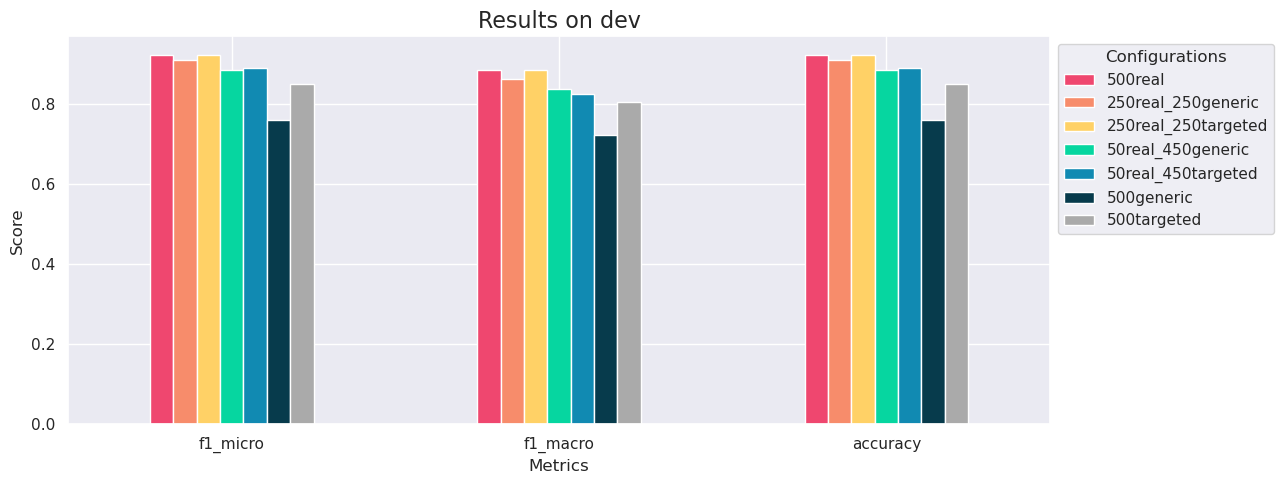

In [30]:
# df_results = pd.read_csv(os.path.join(FOLDER_DIR, "results_RoBERTA.csv"))

plot_df = df_results.set_index('method')
colors = ['#ef476f', '#f78c6b', '#ffd166', '#06d6a0', '#118ab2', '#073b4c', '#aaaaaa']
ax = plot_df.T.plot(kind='bar', figsize=(13, 5), color=colors)

plt.title('Results on dev', fontsize=16)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Configurations', bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()